![banner](https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/main/sesiones/sesion10/sesion10_banner.png)

In [16]:
!pip install ipycanvas -q
!wget https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/e59d7eb5aa9ffe6218705a4c48a060d5d0e98eef/sesiones/sesion10/quokka_example.jpg

--2025-05-19 22:24:43--  https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/e59d7eb5aa9ffe6218705a4c48a060d5d0e98eef/sesiones/sesion10/quokka_example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258826 (253K) [image/jpeg]
Saving to: ‘quokka_example.jpg.2’

quokka_example.jpg. 100%[===================>] 252.76K  1.57MB/s    in 0.2s    

2025-05-19 22:24:43 (1.57 MB/s) - ‘quokka_example.jpg.2’ saved [258826/258826]



In [17]:
#@title **Load required libraries**

import cv2
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

from ipycanvas import Canvas
from IPython.display import display, clear_output
from skimage.metrics import structural_similarity as ssim
from ipywidgets import Button, HBox, VBox, IntText, FloatText, Label, Output, RadioButtons, FloatSlider

In [18]:
from google.colab import output
output.enable_custom_widget_manager()

# **Utils**

In [5]:
def make_gaussian_kernel(size, sigma):
    """Return a normalized 2D Gaussian kernel of given size and sigma."""
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel.astype(np.float32)

def util_convolve_2d(image_channel, kernel):
    """Performs 2D convolution."""
    return scipy.signal.convolve2d(image_channel, kernel, mode='same', boundary='wrap')

def util_get_flipped_kernel(kernel):
    """Flips a kernel (for convolution vs. correlation)."""
    return np.flip(kernel)

def app_on_mouse_down(x_coord, y_coord):
    global g_is_mouse_down_on_canvas
    g_is_mouse_down_on_canvas = True
    deblur_canvas.begin_path()
    deblur_canvas.move_to(x_coord, y_coord)

def app_on_mouse_up(x_coord, y_coord):
    global g_is_mouse_down_on_canvas
    g_is_mouse_down_on_canvas = False

def app_on_mouse_move(x_coord, y_coord):
    global g_is_mouse_down_on_canvas
    if g_is_mouse_down_on_canvas:
        deblur_canvas.line_to(x_coord, y_coord)
        deblur_canvas.stroke()

def util_extract_kernel_from_canvas():
    global deblur_canvas # Uses the global canvas instance
    img_data = deblur_canvas.get_image_data()
    drawn_kernel_raw = img_data[:, :, 0].astype(np.float32)
    if drawn_kernel_raw.sum() < 1e-6:
        return None
    resized_kernel = cv2.resize(
        drawn_kernel_raw, (KERNEL_PROCESS_SIZE, KERNEL_PROCESS_SIZE), interpolation=cv2.INTER_LINEAR
    )
    if resized_kernel.sum() < 1e-6:
        return None
    return resized_kernel / resized_kernel.sum()

def util_get_kernel():
    if kernel_type_selector.value == 'Canvas-drawn':
        kernel = util_extract_kernel_from_canvas()
        if kernel is None:
            raise ValueError("No kernel drawn in canvas.")
        return kernel
    elif kernel_type_selector.value == 'Gaussian':
        return make_gaussian_kernel(KERNEL_PROCESS_SIZE, gaussian_sigma_slider.value)
    else:
        raise ValueError("Unknown kernel type.")

def util_calculate_psnr(img_true, img_test, max_val=1.0):
    img_true_f = img_true.astype(np.float64)
    img_test_f = img_test.astype(np.float64)
    mse = np.mean((img_true_f - img_test_f) ** 2)
    if mse < 1e-10: # Avoid division by zero or very small numbers
        return float('inf')
    return 20 * np.log10(max_val / np.sqrt(mse))

def cb_clear_canvas_action(b):
    global deblur_canvas
    with out_log_and_plots: clear_output(wait=True)
    deblur_canvas.clear()
    deblur_canvas.fill_style = 'black'
    deblur_canvas.fill_rect(0, 0, CANVAS_DRAW_SIZE, CANVAS_DRAW_SIZE)
    out_log_and_plots.append_stdout("Kernel canvas cleared.\n")

def cb_blur_image_action(b):
    global g_original_rgb, g_blurred_rgb, g_blur_kernel_from_canvas
    with out_log_and_plots: clear_output(wait=True)

    try:
        g_blur_kernel_from_canvas = util_get_kernel()
    except ValueError as e:
        out_log_and_plots.append_stdout(str(e) + "\n")
        return
    if g_blur_kernel_from_canvas is None:
        out_log_and_plots.append_stdout("ERROR: Could not extract kernel. Please draw something on the canvas first.\n")
        return

    img_to_process_rgb = None

    try:
        img_bgr = cv2.imread('quokka_example.jpg') # Ensure this file exists or change path
        if img_bgr is None: raise FileNotFoundError("Image 'quokka_example.jpg' not loaded, cv2.imread returned None.")
        img_to_process_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        out_log_and_plots.append_stdout(f"Loaded 'quokka_example.jpg' (original size: {img_to_process_rgb.shape[1]}x{img_to_process_rgb.shape[0]}).\n")
    except FileNotFoundError as e:
        out_log_and_plots.append_stdout(f"INFO: 'quokka_example.jpg' not found ({e}). Using a placeholder image.\n")
        _x_coords = np.linspace(0, 1, 256)
        _y_coords = np.linspace(0, 1, 256)
        _grid_x, _grid_y = np.meshgrid(_x_coords, _y_coords)
        img_to_process_rgb = np.zeros((256, 256, 3), dtype=np.float32)
        img_to_process_rgb[..., 0] = _grid_x
        img_to_process_rgb[..., 1] = _grid_y
        img_to_process_rgb[..., 2] = np.sin(np.pi * _grid_x**2) * np.cos(np.pi * _grid_y**2)
        img_to_process_rgb = np.clip(img_to_process_rgb, 0, 1)
        out_log_and_plots.append_stdout(f"Using placeholder (original size: {img_to_process_rgb.shape[1]}x{img_to_process_rgb.shape[0]}).\n")

    target_width = widget_resize_width.value
    target_height = widget_resize_height.value

    if target_width > 0 and target_height > 0:
        g_original_rgb = cv2.resize(img_to_process_rgb, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
        out_log_and_plots.append_stdout(f"Image resized to {target_width}x{target_height}.\n")
    else:
        g_original_rgb = img_to_process_rgb
        out_log_and_plots.append_stdout(f"Using image at its current size: {g_original_rgb.shape[1]}x{g_original_rgb.shape[0]}.\n")

    g_blurred_rgb = np.zeros_like(g_original_rgb)
    for ch in range(3):
        # Using cv2.filter2D for correlation, which is typical for blurring kernels
        g_blurred_rgb[:, :, ch] = cv2.filter2D(g_original_rgb[:, :, ch], -1, g_blur_kernel_from_canvas)
    g_blurred_rgb = np.clip(g_blurred_rgb, 0, 1)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(g_original_rgb); ax[0].set_title(f"Original (Now {g_original_rgb.shape[1]}x{g_original_rgb.shape[0]})"); ax[0].axis('off')
    psnr_val = util_calculate_psnr(g_original_rgb, g_blurred_rgb)
    ax[1].imshow(g_blurred_rgb); ax[1].set_title(f"Blurred (PSNR: {psnr_val:.2f} dB)"); ax[1].axis('off')
    kernel_display = g_blur_kernel_from_canvas / (g_blur_kernel_from_canvas.max() + 1e-9) # Normalize for display
    ax[2].imshow(kernel_display, cmap='gray', interpolation='nearest'); ax[2].set_title(f"Kernel ({KERNEL_PROCESS_SIZE}x{KERNEL_PROCESS_SIZE})"); ax[2].axis('off')
    plt.tight_layout()
    plt.show()
    out_log_and_plots.append_stdout("Image processed and blurred successfully. Ready for Snippet 2 (Landweber Deblurring).\n")

# **Draw your kernel**

RuntimeError: No image data, please be sure that ``sync_image_data`` is set to True

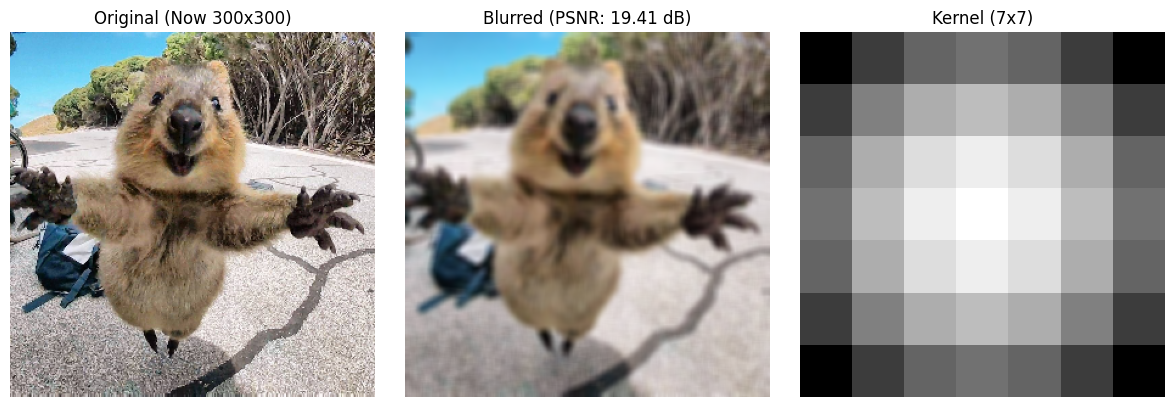

In [19]:
CANVAS_DRAW_SIZE = 200
KERNEL_PROCESS_SIZE = 7  # Kernel will be resized to this
CANVAS_LINE_WIDTH = 10    # Thickness of the drawing line

g_original_rgb = None
g_blurred_rgb = None
g_blur_kernel_from_canvas = None

g_is_mouse_down_on_canvas = False

# ==============================================================================
# 2. CANVAS CREATION AND CONFIGURATION
# ==============================================================================
deblur_canvas = Canvas(width=CANVAS_DRAW_SIZE, height=CANVAS_DRAW_SIZE, sync_image_data=True)
deblur_canvas.layout.width = f'{CANVAS_DRAW_SIZE}px'
deblur_canvas.layout.height = f'{CANVAS_DRAW_SIZE}px'
deblur_canvas.fill_style = 'black'
deblur_canvas.fill_rect(0, 0, CANVAS_DRAW_SIZE, CANVAS_DRAW_SIZE)
deblur_canvas.stroke_style = 'white'
deblur_canvas.line_width = CANVAS_LINE_WIDTH

deblur_canvas.on_mouse_down(app_on_mouse_down)
deblur_canvas.on_mouse_up(app_on_mouse_up)
deblur_canvas.on_mouse_move(app_on_mouse_move)

out_log_and_plots = Output(layout={'padding': '5px', 'width': '98%', 'border': '1px solid lightgray'})

btn_action_clear_canvas = Button(description="Clear Kernel Canvas")
widget_resize_width = IntText(value=0, description='Resize W (0=orig):', style={'description_width': 'initial'}, layout={'width': '200px'})
widget_resize_height = IntText(value=0, description='Resize H (0=orig):', style={'description_width': 'initial'}, layout={'width': '200px'})
btn_action_blur_image = Button(description="Load Image, Resize & Blur")

btn_action_clear_canvas.on_click(cb_clear_canvas_action)
btn_action_blur_image.on_click(cb_blur_image_action)


kernel_type_selector = RadioButtons(
    options=['Canvas-drawn', 'Gaussian'],
    value='Canvas-drawn',
    description='Kernel type:'
)
gaussian_sigma_slider = FloatSlider(
    value=2.0, min=0.5, max=8.0, step=0.1, description='σ (Gaussian):', continuous_update=False
)

ui_section_kernel_drawing = VBox([
    Label("Step 1: Draw Blur Kernel OR Select Gaussian"),
    deblur_canvas,
    HBox([btn_action_clear_canvas]),
    kernel_type_selector,
    gaussian_sigma_slider,
    Label("Optional: Resize image before blurring (Width/Height, 0 for original size)"),
    HBox([widget_resize_width, widget_resize_height]),
    btn_action_blur_image
])


display(VBox([
    ui_section_kernel_drawing,
    Label("Output Log & Plots:"),
    out_log_and_plots
]))

with out_log_and_plots:
    out_log_and_plots.append_stdout("Interface ready. Please draw a kernel on the canvas.\n")
    out_log_and_plots.append_stdout("You can specify resize dimensions for the image before blurring.\n")
    out_log_and_plots.append_stdout("Ensure 'quokka_example.jpg' is in the same directory, or a placeholder image will be used.\n")
    out_log_and_plots.append_stdout("After blurring, run Snippet 2 for deblurring.\n")

## **TV Regularization**

In [20]:
def prox_tv_chambolle(v, weight, n_iter=50, tol=1e-5):
    """
    Proximal operator for isotropic TV using Chambolle's algorithm.
    v: input image (2D array, float)
    weight: TV regularization parameter (lambda*step_size)
    n_iter: number of iterations (default 50)
    Returns: denoised image
    """
    m, n = v.shape
    px = np.zeros((m, n), dtype=np.float32)  # Dual variable (horizontal)
    py = np.zeros((m, n), dtype=np.float32)  # Dual variable (vertical)

    tau = 0.125  # Step size, must be <= 0.25 for convergence

    for _ in range(n_iter):
        # Compute gradient of the divergence
        div_p = np.zeros_like(v)
        div_p[:-1, :] += px[:-1, :]
        div_p[1:, :]  -= px[:-1, :]
        div_p[:, :-1] += py[:, :-1]
        div_p[:, 1:]  -= py[:, :-1]

        # Update
        x = v - weight * div_p

        # Compute gradients of x
        grad_x = np.zeros_like(v)
        grad_y = np.zeros_like(v)
        grad_x[:-1, :] = x[1:, :] - x[:-1, :]
        grad_y[:, :-1] = x[:, 1:] - x[:, :-1]

        denom = 1.0 + tau * np.sqrt(grad_x**2 + grad_y**2)
        px = (px + tau * grad_x) / denom
        py = (py + tau * grad_y) / denom

    # Final update
    div_p = np.zeros_like(v)
    div_p[:-1, :] += px[:-1, :]
    div_p[1:, :]  -= px[:-1, :]
    div_p[:, :-1] += py[:, :-1]
    div_p[:, 1:]  -= py[:, :-1]
    x = v - weight * div_p
    return x

# **Deblurring Problem Formulation**

Image deblurring is the task of recovering a sharp, "true" image from a blurred and often noisy observation. The blurring process can be caused by various factors, including camera motion, out-of-focus optics, atmospheric turbulence, or object movement. Mathematically, this degradation process is often modeled as a convolution operation.

## **The Degradation Model**

Let $x$ represent the true, uncorrupted latent image (which we want to recover) and $y$ represent the observed blurred image. The relationship between $x$ and $y$ can be expressed as:

$y = Hx + n$

Where:

*   **$x$**: The true latent image, typically represented as a 2D array of pixel intensities (or a 3D array for color images, where each channel is processed). In a vectorized form, $x$ can be considered a vector of size $N$ (where $N$ is the total number of pixels).
*   **$y$**: The observed blurred image, also a vector of size $M$ (usually $M=N$, assuming the image dimensions don't change).
*   **$H$**: The degradation operator, often called the blur operator or Point Spread Function (PSF) matrix.
    *   For linear, space-invariant blur, $H$ represents a convolution operation with a blur kernel (PSF), denoted as $h$. The equation in image space becomes:
        $y(i,j) = (h * x)(i,j) + n(i,j)$
        In LaTeX:
        $$
        y(i,j) = \sum_{k,l} h(k,l) x(i-k, j-l) + n(i,j)
        $$
        When images are vectorized, this convolution can be represented by a large, structured matrix $H$ (often block-Toeplitz with Toeplitz blocks for space-invariant blur, or block-circulant with circulant blocks for circular convolution).
*   **$n$**: Additive noise, representing random variations introduced during image acquisition or transmission (e.g., Gaussian noise, Poisson noise).

The goal of image deblurring is to estimate $x$ given $y$ and, ideally, some knowledge of $H$ (the blur kernel $h$) and possibly the noise characteristics.

## **Ill-Posed Nature of Deblurring**

The deblurring problem is a classic example of an **inverse problem**. It is typically **ill-posed** due to several reasons:

1.  **Non-uniqueness:** Different true images $x$ could potentially produce the same blurred image $y$, especially if $H$ has a non-trivial null space (e.g., if the kernel has zeros in its Fourier transform, information at those frequencies is lost).
2.  **Instability:** Small amounts of noise $n$ in the observed image $y$ can lead to very large, unphysical oscillations or errors in the recovered image $x$ if a naive inversion is attempted. This is particularly true when $H$ is ill-conditioned (i.e., its singular values decay rapidly, or its condition number is very large). Attempting a direct deconvolution, such as $X(u,v) = Y(u,v) / H(u,v)$ in the Fourier domain, will amplify noise at frequencies where $H(u,v)$ is small.

## **Solving the Deblurring Problem: Optimization Approach**

To overcome the ill-posed nature, deblurring algorithms typically formulate the problem as an optimization task. This involves defining an objective function (or cost function) that balances two main components:

1.  **Data Fidelity Term:** Ensures that the re-blurred estimate of $x$ is close to the observed image $y$.
2.  **Regularization Term (Prior Term):** Incorporates prior knowledge or desired properties of the true image $x$ (e.g., smoothness, sharp edges, sparsity in a transform domain) to stabilize the solution and select a physically meaningful one.

The general form of the objective function to be minimized with respect to $x$ is:

$\hat{x} = \arg \min_{x} E(x)$

Where $E(x)$ is commonly expressed as:

$$
E(x) = \underbrace{\|Hx - y\|_p^p}_{\text{Data Fidelity Term}} + \underbrace{\lambda R(x)}_{\text{Regularization Term}}
$$

Let's break down the components:

*   **$\|Hx - y\|_p^p$**: The data fidelity term measures the discrepancy between the observed blurred image $y$ and the blurred version of the current estimate $x$.
    *   Commonly, the L2 norm ($p=2$) is used, assuming Gaussian noise:
        $$
        \|Hx - y\|_2^2 = \sum_{i} ( (Hx)_i - y_i )^2
        $$
    *   For Poisson noise (often in medical imaging or astronomy), the Kullback-Leibler (KL) divergence or a Poisson likelihood term might be used.
    *   The L1 norm ($p=1$) can be used for robustness to outliers or specific noise types like salt-and-pepper noise:
        $$
        \|Hx - y\|_1 = \sum_{i} | (Hx)_i - y_i |
        $$

*   **$R(x)$**: The regularization term (or prior). This term imposes constraints or preferences on the solution $x$. Common choices include:
    *   **Tikhonov Regularization (L2 norm of $x$ or its gradient):**
        *   $R(x) = \|x\|_2^2$ (penalizes high intensity values, promotes smoothness)
            $$
            R(x) = \sum_i x_i^2
            $$
        *   $R(x) = \|\nabla x\|_2^2$ (penalizes large gradients, promotes overall smoothness)
            $$
            R(x) = \sum_i \left( (\nabla_h x)_i^2 + (\nabla_v x)_i^2 \right)
            $$
            where $\nabla_h$ and $\nabla_v$ are finite difference operators for horizontal and vertical gradients.
    *   **Total Variation (TV) Regularization (L1 norm of the gradient magnitude):** Excellent for preserving sharp edges while smoothing flat regions.
        *   Isotropic TV:
            $$
            R(x) = \text{TV}(x) = \sum_{i,j} \sqrt{ (\nabla_h x)_{i,j}^2 + (\nabla_v x)_{i,j}^2 }
            $$
        *   Anisotropic TV:
            $$
            R(x) = \text{TV}_1(x) = \sum_{i,j} \left( |(\nabla_h x)_{i,j}| + |(\nabla_v x)_{i,j}| \right)
            $$
    *   **Sparsity-based Regularization:** Assumes the image $x$ is sparse (has few non-zero coefficients) in some transform domain $\Psi$ (e.g., Wavelets, DCT).
        $$
        R(x) = \|\Psi x\|_1 = \sum_k |(\Psi x)_k|
        $$

*   **$\lambda$ (Lambda)**: The regularization parameter. This is a crucial non-negative scalar that controls the trade-off between the data fidelity term and the regularization term.
    *   If $\lambda$ is too small, the solution may be overly sensitive to noise and exhibit artifacts (similar to naive deconvolution).
    *   If $\lambda$ is too large, the solution may be too smooth, lose fine details, and not fit the observed data well.
    *   The optimal value of $\lambda$ often needs to be determined empirically or using methods like L-curve analysis, cross-validation, or discrepancy principles.

## **Common Algorithmic Approaches**

Once the objective function is defined, various optimization algorithms can be employed to find the estimate $\hat{x}$. Some common approaches include:

### **Iterative Methods**

*   **Landweber Iteration:**
    A form of gradient descent applied to $\|Hx - y\|_2^2$. Can incorporate Tikhonov regularization.

    Basic form:
    $$x_{k+1} = x_k - \alpha H^T (Hx_k - y)$$

    With Tikhonov regularization:
    $$
    x_{k+1} = x_k - \alpha (H^T (Hx_k - y) + \lambda x_k)
    $$

*   **Richardson-Lucy Algorithm:**
    An iterative algorithm based on Bayes' theorem, often used for Poisson noise but also applied more generally. It enforces non-negativity. The update rule is typically expressed element-wise for pixel $(i,j)$:

    $$
    x_{k+1}(i,j) = x_k(i,j) \left[ h_{\mathrm{flipped}} * \left( \frac{y}{h * x_k} \right) \right] (i,j)
    $$

    where $*$ denotes convolution, division is element-wise, $h$ is the blur kernel, and $h_{\text{flipped}}$ is its flipped version.

*   **Conjugate Gradient Least Squares (CGLS):**
    An iterative method specifically designed for solving linear systems of equations, including the normal equations $(H^T H + \lambda I)x = H^T y$ that arise from L2-regularized least squares problems. It generally converges faster than simple gradient descent for this type of problem. The algorithm involves constructing a sequence of conjugate search directions to efficiently minimize the quadratic objective.

*   **Proximal Gradient Methods (e.g., ISTA, FISTA):**
    These methods are suitable for objective functions of the form $f(x) + g(x)$, where $f(x)$ is smooth (like the data fidelity term $\|Hx - y\|_2^2$) and $g(x)$ is convex but possibly non-smooth (like L1 norm or Total Variation regularizers). They combine a gradient descent step on $f(x)$ with a proximal operator step related to $g(x)$.

    For example, the Iterative Shrinkage-Thresholding Algorithm (ISTA) for $E(x) = \frac{1}{2}\|Hx - y\|_2^2 + \lambda \|x\|_1$ has the update:

    $$
    x_{k+1} = \operatorname{prox}_{\lambda \alpha \Vert\cdot\Vert_1} (x_k - \alpha H^T(Hx_k - y))
    $$

    where $\operatorname{prox}_{\lambda \alpha \Vert\cdot\Vert_1}$ is the soft-thresholding operator. FISTA (Fast ISTA) provides accelerated convergence.

*   **Alternating Direction Method of Multipliers (ADMM):**
    ADMM is a powerful optimization algorithm that can solve problems by breaking them into smaller, more manageable subproblems. It's particularly effective for problems with complex regularizers or constraints. It introduces auxiliary variables and uses an augmented Lagrangian approach, iteratively updating the primary variables, auxiliary variables, and dual variables (Lagrange multipliers).

# **Deblurring Iterative Algorithms**

### **Landweber Algorithm**

The Landweber iteration **with Tikhonov regularization** is:

$$
x^{(k+1)} = x^{(k)} - \alpha \left[ K^\top (K x^{(k)} - y) + \lambda x^{(k)} \right] \tag{2}
$$

where:
- $x^{(k)}$ is the estimate at iteration $k$
- $K$ is the convolution (blur) operator
- $y$ is the observed (blurred) image
- $\alpha$ is the step size (learning rate)
- $K^\top$ is the adjoint operator of $K$
- $\lambda$ is the Tikhonov regularization parameter

Data from Snippet 1 found. Proceeding with Landweber deblurring...
Starting Landweber: 20 iters, alpha=0.01, beta=0.1
Iter 1/20, Alpha: 0.01, Beta: 0.1, Current PSNR: 19.41 dB, Current SSIM: 0.439
Iter 5/20, Alpha: 0.01, Beta: 0.1, Current PSNR: 19.41 dB, Current SSIM: 0.439
Iter 10/20, Alpha: 0.01, Beta: 0.1, Current PSNR: 19.41 dB, Current SSIM: 0.440
Iter 15/20, Alpha: 0.01, Beta: 0.1, Current PSNR: 19.41 dB, Current SSIM: 0.441
Iter 20/20, Alpha: 0.01, Beta: 0.1, Current PSNR: 19.39 dB, Current SSIM: 0.442

Deblurring complete. Final PSNR (vs Original): 19.39 dB


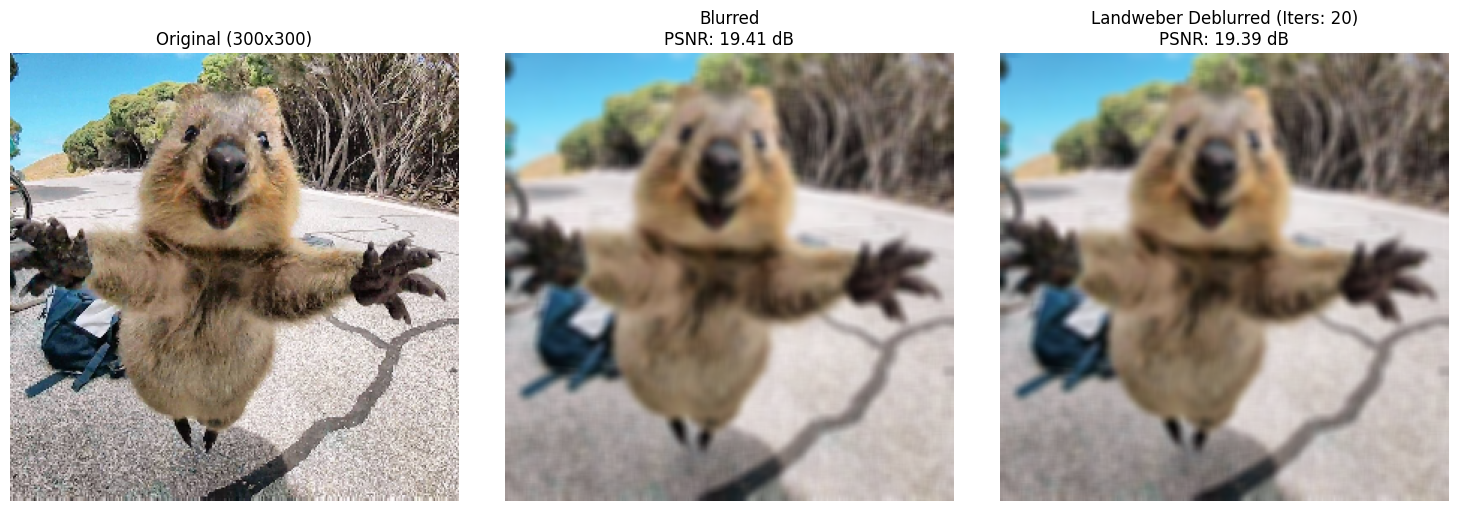

In [23]:
def landweber_deblur_rgb(y_blurred_rgb,
                              kernel_used_for_filter2d,
                              iterations,
                              alpha,
                              reg_beta=0.0,
                              x_true_rgb=None):

    k_fwd_op = util_get_flipped_kernel(kernel_used_for_filter2d)
    k_adj_op = np.copy(kernel_used_for_filter2d)

    x_reconstructed_rgb = np.copy(y_blurred_rgb)

    print(f"Starting Landweber: {iterations} iters, alpha={alpha}, beta={reg_beta}")

    for i in range(iterations):
        for ch in range(3): # Process R, G, B channels
            x_ch = x_reconstructed_rgb[:, :, ch]
            y_ch = y_blurred_rgb[:, :, ch]

            convolved_x = util_convolve_2d(x_ch,k_fwd_op)    # K_fwd * x_old
            residual = convolved_x - y_ch                     # (K_fwd * x_old - y)
            data_gradient_term = util_convolve_2d(residual, k_adj_op) # K_adj * (residual)

            if reg_beta > 0:
                regularization_term_gradient = reg_beta * x_ch
                total_gradient = data_gradient_term + regularization_term_gradient
            else:
                total_gradient = data_gradient_term

            x_ch = x_ch - alpha * total_gradient # Update step
            x_reconstructed_rgb[:, :, ch] = np.clip(x_ch, 0, 1)

        if (i + 1) % 5 == 0 or i == 0 or i == iterations - 1:
            if x_true_rgb is not None:
                # util_calculate_psnr is defined in Snippet 1 and available here
                psnr = util_calculate_psnr(x_true_rgb, x_reconstructed_rgb)
                current_ssim = ssim(x_true_rgb, x_reconstructed_rgb,data_range=x_true_rgb.max() - x_true_rgb.min(), channel_axis=-1, win_size=7)
                print(f"Iter {i+1}/{iterations}, Alpha: {alpha}, Beta: {reg_beta}, Current PSNR: {psnr:.2f} dB, Current SSIM: {current_ssim:.3f}")
            else:
                print(f"Iter {i+1}/{iterations}, Beta: {reg_beta} completed.")
    return x_reconstructed_rgb

# Check if necessary variables from Snippet 1 exist
if 'g_blurred_rgb' not in globals() or g_blurred_rgb is None or \
   'g_blur_kernel_from_canvas' not in globals() or g_blur_kernel_from_canvas is None or \
   'g_original_rgb' not in globals() or g_original_rgb is None:
    print("ERROR: Necessary data (g_blurred_rgb, g_blur_kernel_from_canvas, g_original_rgb) not found.")
    print("Please run Snippet 1 first and ensure an image is loaded and blurred.")
else:
    print("Data from Snippet 1 found. Proceeding with Landweber deblurring...")

    # --- Set Landweber Parameters Here ---
    lw_iterations = 20
    lw_alpha = 0.01
    lw_reg_beta = 0.1
    # --- End Parameters ---

    # Perform deblurring
    reconstructed_rgb = landweber_deblur_rgb(
        g_blurred_rgb,
        g_blur_kernel_from_canvas,
        lw_iterations,
        lw_alpha,
        reg_beta=lw_reg_beta,
        x_true_rgb=g_original_rgb
    )

    final_psnr = util_calculate_psnr(g_original_rgb, reconstructed_rgb)
    print(f"\nDeblurring complete. Final PSNR (vs Original): {final_psnr:.2f} dB")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(g_original_rgb)
    ax[0].set_title(f"Original ({g_original_rgb.shape[1]}x{g_original_rgb.shape[0]})")
    ax[0].axis('off')

    psnr_blurred = util_calculate_psnr(g_original_rgb, g_blurred_rgb)
    ax[1].imshow(g_blurred_rgb)
    ax[1].set_title(f"Blurred\nPSNR: {psnr_blurred:.2f} dB")
    ax[1].axis('off')

    ax[2].imshow(reconstructed_rgb)
    ax[2].set_title(f"Landweber Deblurred (Iters: {lw_iterations})\nPSNR: {final_psnr:.2f} dB")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

### Richardson-Lucy Deconvolution with Total Variation (TV) Regularization

The Richardson-Lucy iteration with TV regularization for each channel is:

$$
x^{(k+1)} = \operatorname{prox}_{\lambda \,\mathrm{TV}} \left(
    x^{(k)} \cdot
    K^\top \left( \frac{y}{K x^{(k)} + \epsilon} \right)
\right)
$$

where:
- $x^{(k)}$ is the current estimate of the latent image at iteration $k$
- $K$ is the forward blur operator (convolution with the flipped kernel)
- $K^\top$ is the adjoint operator (convolution with the original kernel)
- $y$ is the observed (blurred) image
- $\epsilon$ is a small constant to avoid division by zero
- $\cdot$ denotes element-wise multiplication
- $\operatorname{prox}_{\lambda \,\mathrm{TV}}$ is the proximal operator for TV regularization with parameter $\lambda$

**Algorithm steps:**
1. For each color channel $ch$:
    - Compute the forward blur: $K x^{(k)}$
    - Compute the ratio: $r = y / (K x^{(k)} + \epsilon)$
    - Compute the correction factor: $K^\top(r)$
    - Update: $x_{\text{ch}} \gets x_{\text{ch}} \cdot K^\top(r)$
    - Apply the TV proximal operator: $x_{\text{ch}} \leftarrow prox_{\lambda\, TV}(x_{ch})$

2. Clip the result to $[0, 1]$.

**Where:**
- The forward operator $K$ is convolution with the flipped kernel:  
  `k_fwd_op = util_get_flipped_kernel(kernel_used_for_filter2d)`
- The adjoint operator $K^\top$ is convolution with the original kernel:  
  `k_adj_op = np.copy(kernel_used_for_filter2d)`


Proceeding with deblurring example.

--- Running Richardson-Lucy Deblurring ---
Starting Richardson-Lucy + TV: 15 iterations, TV λ=0.001
Iter 1/15, PSNR: 20.90 dB, SSIM: 0.638
Iter 2/15, PSNR: 21.16 dB, SSIM: 0.662
Iter 3/15, PSNR: 21.37 dB, SSIM: 0.682
Iter 4/15, PSNR: 21.56 dB, SSIM: 0.698
Iter 5/15, PSNR: 21.73 dB, SSIM: 0.712
Iter 6/15, PSNR: 21.89 dB, SSIM: 0.725
Iter 7/15, PSNR: 22.03 dB, SSIM: 0.736
Iter 8/15, PSNR: 22.17 dB, SSIM: 0.747
Iter 9/15, PSNR: 22.30 dB, SSIM: 0.757
Iter 10/15, PSNR: 22.42 dB, SSIM: 0.766
Iter 11/15, PSNR: 22.54 dB, SSIM: 0.774
Iter 12/15, PSNR: 22.65 dB, SSIM: 0.782
Iter 13/15, PSNR: 22.75 dB, SSIM: 0.789
Iter 14/15, PSNR: 22.85 dB, SSIM: 0.796
Iter 15/15, PSNR: 22.94 dB, SSIM: 0.802
Richardson-Lucy complete. Final PSNR: 22.94 dB


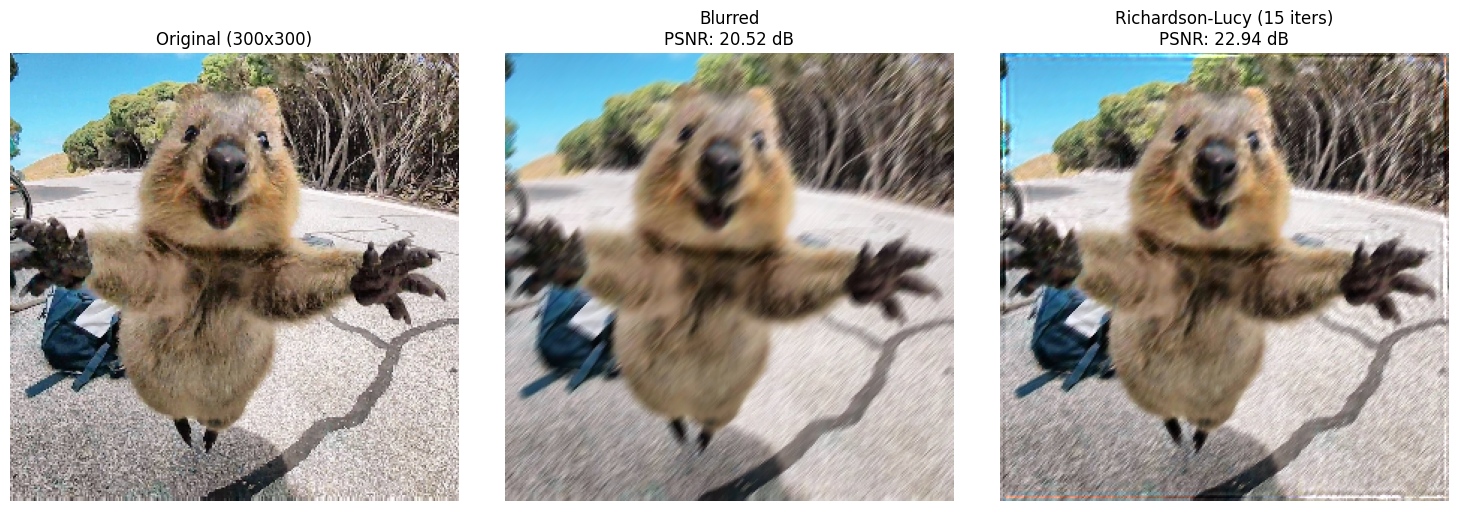

In [ ]:
def algo_richardson_lucy_deblur_rgb(
    y_blurred_rgb,
    kernel_used_for_filter2d,
    iterations,
    tv_lambda=0.01,
    x_true_rgb=None,
    epsilon=1e-8
):

    k_fwd_op = util_get_flipped_kernel(kernel_used_for_filter2d)
    k_adj_op = np.copy(kernel_used_for_filter2d)

    x_reconstructed_rgb = np.copy(y_blurred_rgb).astype(np.float32)
    x_reconstructed_rgb = np.clip(x_reconstructed_rgb, epsilon, 1.0)

    print(f"Starting Richardson-Lucy + TV: {iterations} iterations, TV λ={tv_lambda}")

    for i in range(iterations):
        for ch in range(3):
            x_ch = x_reconstructed_rgb[:, :, ch]
            y_ch = y_blurred_rgb[:, :, ch]

            # --- RL multiplicative update ---
            blurred_estimate_ch = util_convolve_2d(x_ch, k_fwd_op)

            blurred_estimate_ch = np.clip(blurred_estimate_ch, epsilon, None)

            ratio_ch = y_ch / blurred_estimate_ch
            correction_factor_ch = None

            x_ch = None

            # --- Proximal TV (Chambolle) ---
            x_ch = prox_tv_chambolle(x_ch, weight=tv_lambda, n_iter=30)

            x_reconstructed_rgb[:, :, ch] = np.clip(x_ch, 0, 1)

        if (i + 1) % 1 == 0 or i == 0 or i == iterations - 1:
            if x_true_rgb is not None:
                psnr = util_calculate_psnr(x_true_rgb, x_reconstructed_rgb)
                current_ssim = ssim(
                    x_true_rgb, x_reconstructed_rgb,
                    data_range=x_true_rgb.max() - x_true_rgb.min(),
                    channel_axis=-1, win_size=7
                )
                print(f"Iter {i+1}/{iterations}, PSNR: {psnr:.2f} dB, SSIM: {current_ssim:.3f}")
            else:
                print(f"Iter {i+1}/{iterations} completed.")

    return x_reconstructed_rgb

if 'g_blurred_rgb' not in globals() or g_blurred_rgb is None or \
   'g_blur_kernel_from_canvas' not in globals() or g_blur_kernel_from_canvas is None or \
   'g_original_rgb' not in globals() or g_original_rgb is None:
    print("ERROR: Necessary data (g_blurred_rgb, g_blur_kernel_from_canvas, g_original_rgb) not found.")
    print("Please run Snippet 1 first and ensure an image is loaded and blurred.")
else:
    print("Proceeding with deblurring example.")

    # --- Parameters for Richardson-Lucy ---
    rl_iterations = 15

    # Perform Richardson-Lucy deblurring
    print("\n--- Running Richardson-Lucy Deblurring ---")
    reconstructed_rl_rgb = algo_richardson_lucy_deblur_rgb(
        g_blurred_rgb,
        g_blur_kernel_from_canvas,
        rl_iterations,
        tv_lambda=0.001,
        x_true_rgb=g_original_rgb,
        epsilon=1e-8,
    )
    final_psnr_rl = util_calculate_psnr(g_original_rgb, reconstructed_rl_rgb)
    print(f"Richardson-Lucy complete. Final PSNR: {final_psnr_rl:.2f} dB")

    num_images_to_show = 3

    fig, ax = plt.subplots(1, num_images_to_show, figsize=(5 * num_images_to_show, 5))

    ax[0].imshow(g_original_rgb)
    ax[0].set_title(f"Original ({g_original_rgb.shape[1]}x{g_original_rgb.shape[0]})")
    ax[0].axis('off')

    psnr_blurred = util_calculate_psnr(g_original_rgb, g_blurred_rgb)
    ax[1].imshow(g_blurred_rgb)
    ax[1].set_title(f"Blurred\nPSNR: {psnr_blurred:.2f} dB")
    ax[1].axis('off')

    ax[2].imshow(reconstructed_rl_rgb)
    ax[2].set_title(f"Richardson-Lucy ({rl_iterations} iters)\nPSNR: {final_psnr_rl:.2f} dB")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

### ISTA / FISTA for Deblurring with TV Regularization

The ISTA/FISTA iteration for image deblurring with TV regularization is:

$$
\begin{align*}
&\textbf{Gradient step:} \\
&\qquad x_\text{tmp} = z^{(k)} - \gamma \cdot K^\top (K z^{(k)} - y) \\[1.5ex]
&\textbf{Proximal (TV):} \\
&\qquad x^{(k+1)} = \text{prox}_{\gamma\, \mathrm{TV}}(x_\text{tmp}) \\[1.5ex]
&\textbf{FISTA update:} \\
&\qquad t_{k+1} = \frac{1+\sqrt{1+4t_k^2}}{2} \\
&\qquad z^{(k+1)} = x^{(k+1)} + \frac{t_k - 1}{t_{k+1}} \left(x^{(k+1)} - x^{(k)}\right)
\end{align*}
$$

where:

- $x^{(k)}$ is the estimate at iteration $k$
- $z^{(k)}$ is the accelerated variable (for FISTA; $z^{(k)} = x^{(k)}$ for ISTA)
- $K$ is the forward blur operator (convolution with the flipped kernel)
- $K^\top$ is the adjoint operator (convolution with the original kernel)
- $y$ is the observed (blurred) image
- $\gamma$ is the step size (learning rate)
- $\text{prox}_{\gamma\, \mathrm{TV}}$ is the proximal operator for TV with parameter $\gamma$
- $t_k$ is the FISTA momentum parameter (for ISTA, simply set $z^{(k+1)} = x^{(k+1)}$)

**Notes:**
- When `fista=False`, use only the first two steps (ISTA).
- The TV proximal is typically solved with Chambolle's algorithm.
- Each channel is processed independently.



 Proceeding with ISTA/FISTA TV deblurring.
Iter 1/35, PSNR: 5.28 dB, SSIM: 0.039
Iter 5/35, PSNR: 4.42 dB, SSIM: 0.000
Iter 10/35, PSNR: 4.42 dB, SSIM: 0.000
Iter 15/35, PSNR: 4.42 dB, SSIM: 0.000
Iter 20/35, PSNR: 4.42 dB, SSIM: 0.000
Iter 25/35, PSNR: 4.42 dB, SSIM: 0.000
Iter 30/35, PSNR: 4.42 dB, SSIM: 0.000
Iter 35/35, PSNR: 4.42 dB, SSIM: 0.000
(F)ISTA-TV complete. Final PSNR: 4.42 dB


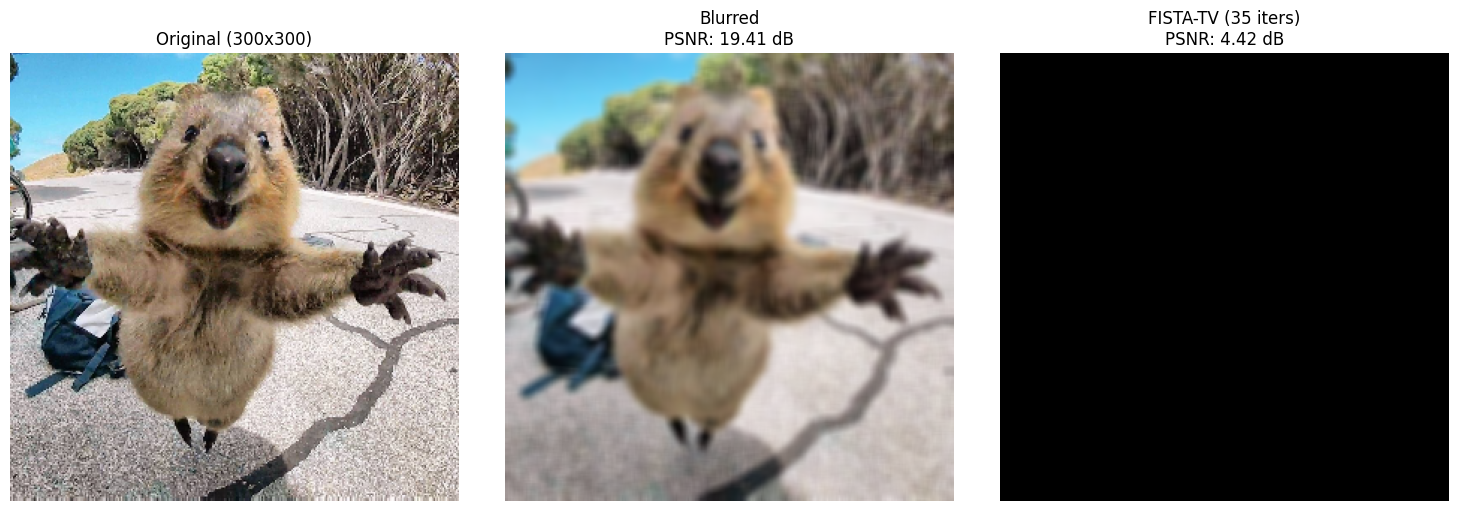

In [26]:
def ista_fista_deblur_rgb(
    y_blurred_rgb,
    kernel_used_for_filter2d,
    iterations,
    step_size=0.1,
    tv_lambda=0.01,
    fista=True,
    x_true_rgb=None,
    verbose=True
):

    k_fwd_op = util_get_flipped_kernel(kernel_used_for_filter2d)
    k_adj_op = np.copy(kernel_used_for_filter2d)

    y = y_blurred_rgb.astype(np.float32)
    x = np.copy(y)  # Initial guess
    z = np.copy(x)  # For FISTA

    t = 0.9

    for i in range(iterations):
        x_old = x.copy()
        for ch in range(3):
            # --- Gradient step ---
            Kz = util_convolve_2d(z[:, :, ch], k_fwd_op)
            grad = util_convolve_2d(Kz, k_adj_op)
            x_tmp = step_size * grad

            # --- Proximal operator for TV (using Chambolle's method) ---
            x[:, :, ch] = prox_tv_chambolle(x_tmp, weight=step_size * tv_lambda, n_iter=50)
            x[:, :, ch] = np.clip(x[:, :, ch], 0, 1)

        if fista:
            t_next = (1 + np.sqrt(1+4**2)) / 2
            z = x + ((t - 1) / t_next) * (x - x_old)
            t = t_next
        else:
            z = x.copy()

        if verbose and ((i + 1) % 5 == 0 or i == 0 or i == iterations - 1):
            if x_true_rgb is not None:
                psnr = util_calculate_psnr(x_true_rgb, x)
                ssim_val = ssim(x_true_rgb, x, data_range=x_true_rgb.max()-x_true_rgb.min(), channel_axis=-1)
                print(f"Iter {i+1}/{iterations}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.3f}")

            else:
                print(f"Iter {i+1}/{iterations} completed.")
    return x

# Check required variables
if 'g_blurred_rgb' not in globals() or g_blurred_rgb is None or \
   'g_blur_kernel_from_canvas' not in globals() or g_blur_kernel_from_canvas is None or \
   'g_original_rgb' not in globals() or g_original_rgb is None:
    print("ERROR: Necessary data not found.")
else:
    print("\n Proceeding with ISTA/FISTA TV deblurring.")

    iterations = 35

    reconstructed_tv_rgb = ista_fista_deblur_rgb(
        g_blurred_rgb,
        g_blur_kernel_from_canvas,
        iterations,
        step_size=0.1,
        tv_lambda=0.001,
        fista=True,
        x_true_rgb=g_original_rgb,
        verbose=True
    )
    final_psnr_tv = util_calculate_psnr(g_original_rgb, reconstructed_tv_rgb)
    print(f"(F)ISTA-TV complete. Final PSNR: {final_psnr_tv:.2f} dB")

    # Show results
    num_images_to_show = 3
    fig, ax = plt.subplots(1, num_images_to_show, figsize=(5 * num_images_to_show, 5))

    ax[0].imshow(g_original_rgb)
    ax[0].set_title(f"Original ({g_original_rgb.shape[1]}x{g_original_rgb.shape[0]})")
    ax[0].axis('off')

    psnr_blurred = util_calculate_psnr(g_original_rgb, g_blurred_rgb)
    ax[1].imshow(g_blurred_rgb)
    ax[1].set_title(f"Blurred\nPSNR: {psnr_blurred:.2f} dB")
    ax[1].axis('off')

    ax[2].imshow(reconstructed_tv_rgb)
    ax[2].set_title(f"FISTA-TV ({iterations} iters)\nPSNR: {final_psnr_tv:.2f} dB")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

### Conjugate Gradient for Least Squares (CGLS) with Tikhonov Regularization

The CGLS algorithm solves the Tikhonov-regularized deblurring problem:

$$
\min_x \ \|Kx - y\|^2 + \lambda \|x\|^2
$$

where:
- $K$ is the convolution operator (blur kernel)
- $y$ is the observed (blurred) image
- $x$ is the unknown sharp image to recover
- $\lambda$ is the Tikhonov (L2) regularization parameter

The CGLS iterations are as follows (for each channel):

$$
\begin{align*}
&\text{Set} \quad x_0 = 0 \\
&b = K^\top y \\
&r_0 = b \\
&p_0 = r_0 \\
&\text{For } k = 0, 1, \ldots, \text{until convergence:} \\
&\qquad A p_k = K^\top K p_k + \lambda p_k \\
&\qquad \alpha_k = \frac{r_k^\top r_k}{p_k^\top A p_k} \\
&\qquad x_{k+1} = x_k + \alpha_k p_k \\
&\qquad r_{k+1} = r_k - \alpha_k A p_k \\
&\qquad \beta_k = \frac{r_{k+1}^\top r_{k+1}}{r_k^\top r_k} \\
&\qquad p_{k+1} = r_{k+1} + \beta_k p_k \\
\end{align*}
$$

where:
- $K^\top$ is the adjoint operator (convolution with the original kernel)
- $A = K^\top K + \lambda I$

**Notes:**
- The kernel is flipped for the forward operation (`Kx`) and not flipped for the adjoint (`K^\top y`).
- Each color channel is processed independently.
- Convergence is checked by the residual norm $\|r_k\|$.




Data found. Proceeding with CGLS deblurring...
Ch 0, Iter 1/70, PSNR: 6.21 dB, SSIM: 0.130
Ch 0, Iter 10/70, PSNR: 6.22 dB, SSIM: 0.180
Ch 0, Iter 20/70, PSNR: 6.22 dB, SSIM: 0.180
Ch 0, Iter 30/70, PSNR: 6.22 dB, SSIM: 0.180
Ch 0, Iter 40/70, PSNR: 6.22 dB, SSIM: 0.180
Channel 0 converged at iteration 46 due to small residual.
Ch 1, Iter 1/70, PSNR: 9.12 dB, SSIM: 0.309
Ch 1, Iter 10/70, PSNR: 9.15 dB, SSIM: 0.359
Ch 1, Iter 20/70, PSNR: 9.15 dB, SSIM: 0.359
Ch 1, Iter 30/70, PSNR: 9.15 dB, SSIM: 0.359
Ch 1, Iter 40/70, PSNR: 9.15 dB, SSIM: 0.359
Channel 1 converged at iteration 46 due to small residual.
Ch 2, Iter 1/70, PSNR: 19.26 dB, SSIM: 0.486
Ch 2, Iter 10/70, PSNR: 19.62 dB, SSIM: 0.534
Ch 2, Iter 20/70, PSNR: 19.62 dB, SSIM: 0.535
Ch 2, Iter 30/70, PSNR: 19.62 dB, SSIM: 0.535
Ch 2, Iter 40/70, PSNR: 19.62 dB, SSIM: 0.535
Channel 2 converged at iteration 47 due to small residual.
CGLS Corrected: Final PSNR: 19.62 dB, SSIM: 0.5346
CGLS Deblurring complete. Final PSNR: 19.62 dB


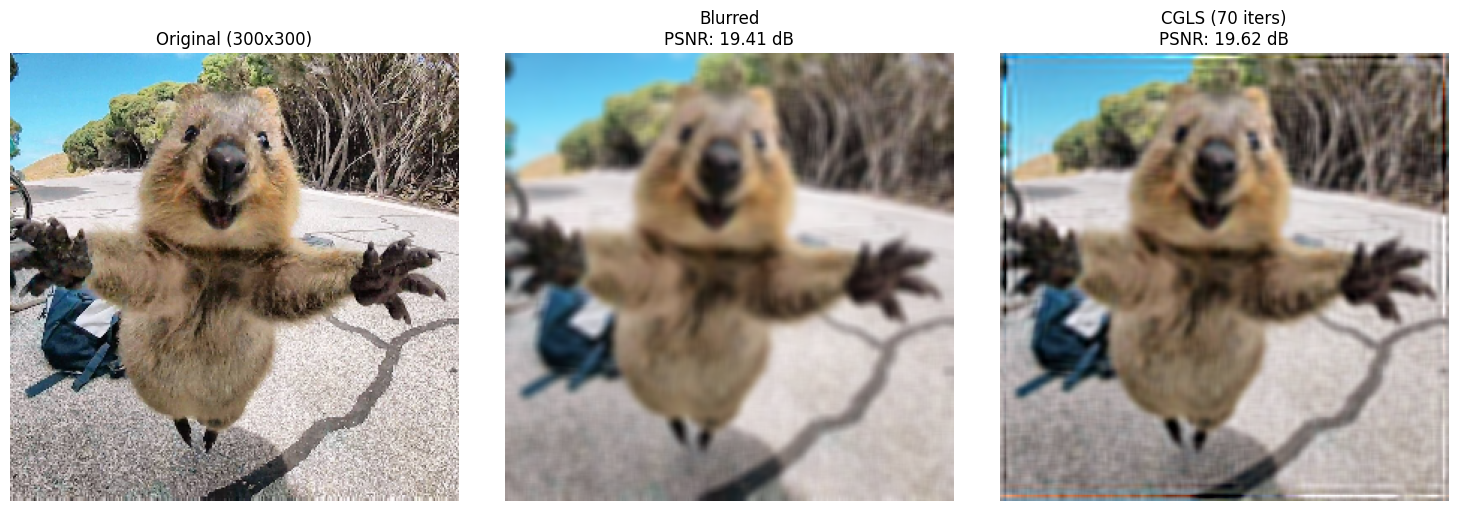

In [28]:
def cgls_deblur_rgb(
    y_blurred_rgb,
    kernel_used_for_filter2d,
    iterations=50,
    tikhonov_lambda=0.001,
    x_true_rgb=None,
    verbose=True
):

    K_conv_kernel = util_get_flipped_kernel(kernel_used_for_filter2d)
    Kt_conv_kernel = kernel_used_for_filter2d

    y = y_blurred_rgb.astype(np.float32)
    x_reconstructed_rgb = np.zeros_like(y, dtype=np.float32)

    for ch in range(3):
        y_ch = y[..., ch]
        x_ch = np.zeros_like(y_ch, dtype=np.float32)
        b_cg = util_convolve_2d(y_ch, Kt_conv_kernel)

        r = b_cg.copy()
        p = r.copy()

        rsold_sum = np.sum(r*r)

        for i in range(iterations):
            Kp_temp = util_convolve_2d(p, K_conv_kernel)
            KtKp_temp = util_convolve_2d(Kp_temp, Kt_conv_kernel)
            Ap_cg = KtKp_temp + tikhonov_lambda * p

            alpha = (rsold_sum/np.sum(p*Ap_cg)+1e-12) # Avoid division by zero

            x_ch = x_ch + alpha * p
            r = r - alpha * Ap_cg

            rsnew_sum = np.sum(r*r)

            if np.sqrt(rsnew_sum) < 1e-7:
                if verbose:
                    print(f"Channel {ch} converged at iteration {i+1} due to small residual.")
                break

            beta = rsnew_sum / (rsold_sum + 1e-12) # Avoid division by zero
            p = r + beta * p
            rsold_sum = rsnew_sum

            if verbose and x_true_rgb is not None and ((i+1) % 10 == 0 or i == 0 or i == iterations-1 or i == iterations -2):

                temp_full_x = np.copy(x_reconstructed_rgb) # Start with current best full image
                temp_full_x[..., ch] = np.clip(x_ch,0,1)    # Put current channel's estimate

                current_psnr = util_calculate_psnr(x_true_rgb, temp_full_x)
                current_ssim_val = ssim(x_true_rgb, temp_full_x, data_range=1.0, channel_axis=-1, win_size=7)
                current_ssim = f"{current_ssim_val:.3f}"

                print(f"Ch {ch}, Iter {i+1}/{iterations}, PSNR: {current_psnr:.2f} dB, SSIM: {current_ssim}")

        x_reconstructed_rgb[..., ch] = np.clip(x_ch, 0, 1)

    final_psnr = util_calculate_psnr(x_true_rgb, x_reconstructed_rgb)
    final_ssim_str = "N/A"

    final_ssim_val = ssim(
        x_true_rgb, x_reconstructed_rgb,
        data_range=1.0,
        channel_axis=-1,
        win_size=7
    )
    final_ssim_str = f"{final_ssim_val:.4f}"
    print(f"CGLS Corrected: Final PSNR: {final_psnr:.2f} dB, SSIM: {final_ssim_str}")

    return x_reconstructed_rgb

if 'g_blurred_rgb' not in globals() or g_blurred_rgb is None or \
   'g_blur_kernel_from_canvas' not in globals() or g_blur_kernel_from_canvas is None or \
   'g_original_rgb' not in globals() or g_original_rgb is None:
    print("ERROR: Necessary data not found.")
else:
    print("\nData found. Proceeding with CGLS deblurring...")

    iterations = 70
    reconstructed_cgls_rgb = cgls_deblur_rgb( # Make sure to call the corrected version
        g_blurred_rgb,
        g_blur_kernel_from_canvas,
        iterations=iterations,
        tikhonov_lambda=0.05,
        x_true_rgb=g_original_rgb,
        verbose=True
    )

    final_psnr_cgls = util_calculate_psnr(g_original_rgb, reconstructed_cgls_rgb)
    print(f"CGLS Deblurring complete. Final PSNR: {final_psnr_cgls:.2f} dB")

    # Show results
    num_images_to_show = 3
    fig, ax = plt.subplots(1, num_images_to_show, figsize=(5 * num_images_to_show, 5))

    ax[0].imshow(g_original_rgb)
    ax[0].set_title(f"Original ({g_original_rgb.shape[1]}x{g_original_rgb.shape[0]})")
    ax[0].axis('off')

    psnr_blurred = util_calculate_psnr(g_original_rgb, g_blurred_rgb)
    ax[1].imshow(g_blurred_rgb)
    ax[1].set_title(f"Blurred\nPSNR: {psnr_blurred:.2f} dB")
    ax[1].axis('off')

    ax[2].imshow(reconstructed_cgls_rgb)
    ax[2].set_title(f"CGLS ({iterations} iters)\nPSNR: {final_psnr_cgls:.2f} dB")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()